Start with some imports

In [1]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
import pulp as pl
import xlsxwriter as xl

Create the CIGRE network

In [2]:

net = nw.create_cigre_network_mv()

1.1 State of the network

In [3]:
pp.runpp(net)
print("Bus voltages")
print(net.res_bus.vm_pu)
print("Trafo loading")
print(net.res_trafo.loading_percent)
print("Line loading")
net.res_line.loading_percent

Bus voltages
0     1.030000
1     0.991972
2     0.968147
3     0.930961
4     0.929098
5     0.927823
6     0.926321
7     0.925122
8     0.925404
9     0.924422
10    0.923174
11    0.922980
12    1.000146
13    0.995326
14    0.992553
Name: vm_pu, dtype: float64
Trafo loading
0    101.411473
1     84.698048
Name: loading_percent, dtype: float64
Line loading


0     96.482978
1     96.958807
2     37.580668
3     28.091021
4     12.122901
5      1.936801
6     33.550914
7     19.476278
8      7.294089
9     48.143637
10     9.476242
11     8.908939
12     0.084082
13     0.171049
14     0.037287
Name: loading_percent, dtype: float64

1.2 N-1 analysis

0 in collections is of unknown type. Skipping


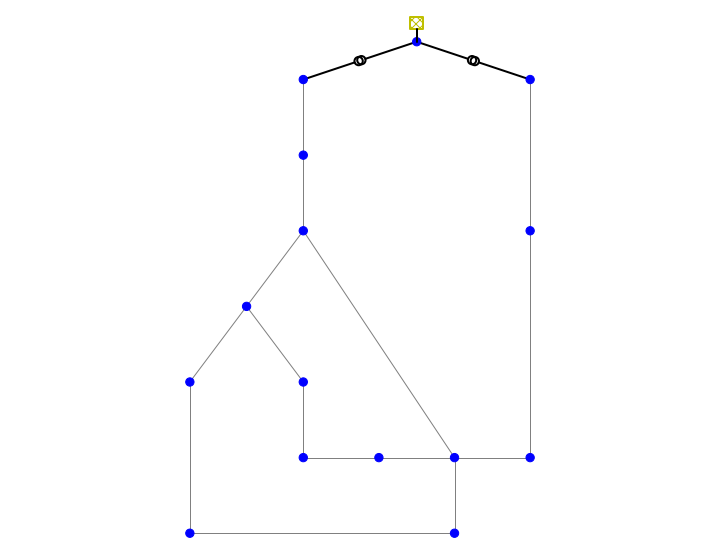

In [4]:
# limits
vmax = 1.1
vmin = .9
max_ll = 100.

lines = net.line.index
critical = list()

for l in lines:
    net.line.loc[l, "in_service"] = False
    pp.runpp(net)

    if net.res_bus.vm_pu.max() > vmax or net.res_bus.vm_pu.min() < vmin or net.res_line.loading_percent.max() > max_ll:
        critical.append(l)
    net.line.loc[l, "in_service"] = True

ax = pplt.simple_plot(net, show_plot=False)
clc = pplt.create_line_collection(net, critical, color="r", linewidth=3., use_bus_geodata=True)
pplt.draw_collections([clc], ax=ax)
plt.show()

1.3 N-1 with smaller limits

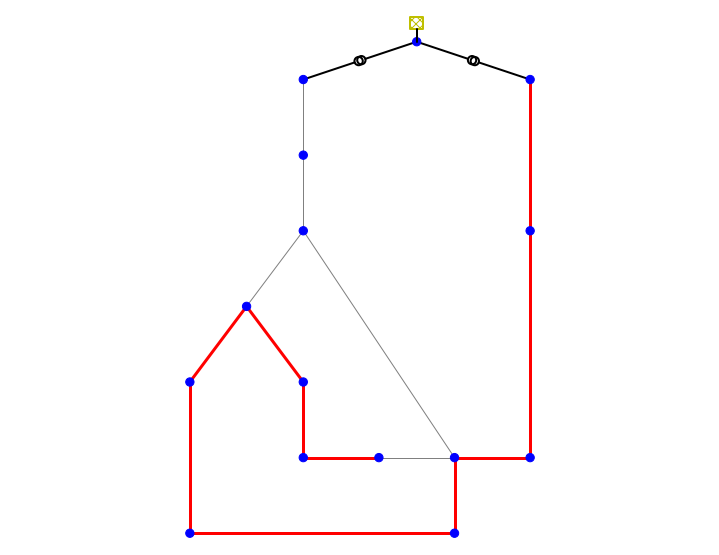

In [5]:
# limits
vmax = 1.05
vmin = .95
max_ll = 100.

lines = net.line.index
critical = list()

for l in lines:
    net.line.loc[l, "in_service"] = False
    pp.runpp(net)

    if net.res_bus.vm_pu.max() > vmax or net.res_bus.vm_pu.min() < vmin or net.res_line.loading_percent.max() > max_ll:
        critical.append(l)
    net.line.loc[l, "in_service"] = True

ax = pplt.simple_plot(net, show_plot=False)
clc = pplt.create_line_collection(net, critical, color="r", linewidth=3., use_bus_geodata=True)
pplt.draw_collections([clc], ax=ax)
plt.show()

2 Add low voltage buses and EV charging stations

In [47]:
# net.bus_geodata

7.0

In [7]:
pp.create_bus(net, name="Bus CS 1", vn_kv=0.4, type="b", geodata=((3,14))) # play around with the geodata
pp.create_bus(net, name="Bus CS 2", vn_kv=0.4, type="b", geodata=((3,10)))
pp.create_bus(net, name="Bus CS 3", vn_kv=0.4, type="b", geodata=((0,6)))
pp.create_bus(net, name="Bus CS 4", vn_kv=0.4, type="b", geodata=((7,2)))
pp.create_bus(net, name="Bus CS 5", vn_kv=0.4, type="b", geodata=((5,4)))
# select high voltage buses to connect the transformers (and thus CVs) to
pp.create_transformer(net, hv_bus=1, lv_bus=pp.get_element_index(net, "bus", "Bus CS 1"), name="CS 1", std_type="0.25 MVA 20/0.4 kV")
pp.create_transformer(net, hv_bus=3, lv_bus=pp.get_element_index(net, "bus", "Bus CS 2"), name="CS 2", std_type="0.25 MVA 20/0.4 kV")
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index(net, "bus", "Bus CS 3"), name="CS 3", std_type="0.25 MVA 20/0.4 kV")
pp.create_transformer(net, hv_bus=7, lv_bus=pp.get_element_index(net, "bus", "Bus CS 4"), name="CS 4", std_type="0.25 MVA 20/0.4 kV")
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index(net, "bus", "Bus CS 5"), name="CS 5", std_type="0.25 MVA 20/0.4 kV")

6

Do some plotting

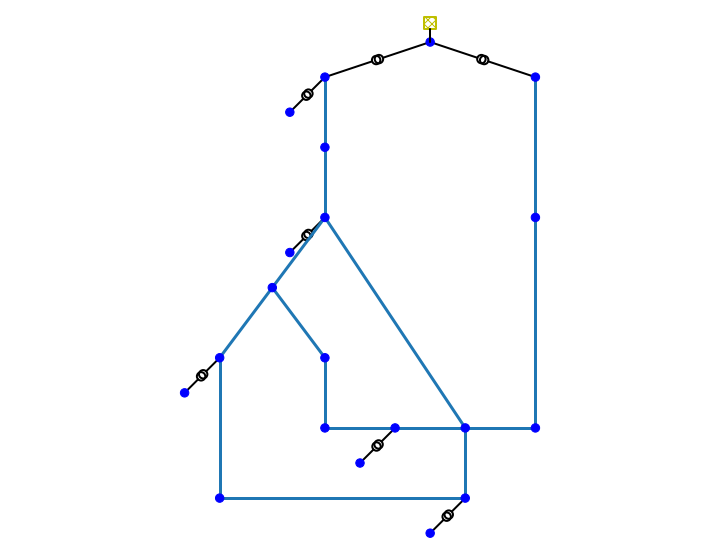

In [8]:
ax = pplt.simple_plot(net, show_plot=False)
clc = pplt.create_line_collection(net, linewidth=3., use_bus_geodata=True)
pplt.draw_collections([clc], ax=ax)
plt.show()

Check existing loads and add EVs

In [42]:
p_mw = np.array(net.load.p_mw).reshape((1,18))
q_mvar = np.array(net.load.q_mvar).reshape((1,18))
loadshape_nominal = np.array([0.28285, 0.272295, 0.2613828, 0.261328, 0.254316, 0.259789, 0.272966, 0.30915, 0.433979, 0.542955, 0.717333, 0.851829, 0.864118, 0.854116, 0.853815, 0.852508, 0.723452, 0.490362, 0.428271, 0.361402, 0.336596, 0.328176, 0.307331, 0.297966]).reshape((24,1))
loadshape_p_mw = np.multiply(loadshape_nominal, p_mw)
loadshape_q_mvar = np.multiply(loadshape_nominal, q_mvar)
# e.g. to access loadshape of load 0 use loadshape_p_mw[:,0]

         name  bus      p_mw    q_mvar  const_z_percent  const_i_percent  \
0     Load R1    1  14.99400  3.044662              0.0              0.0   
1     Load R3    3   0.27645  0.069285              0.0              0.0   
2     Load R4    4   0.43165  0.108182              0.0              0.0   
3     Load R5    5   0.72750  0.182329              0.0              0.0   
4     Load R6    6   0.54805  0.137354              0.0              0.0   
5     Load R8    8   0.58685  0.147078              0.0              0.0   
6    Load R10   10   0.47530  0.119121              0.0              0.0   
7    Load R11   11   0.32980  0.082656              0.0              0.0   
8    Load R12   12  14.99400  3.044662              0.0              0.0   
9    Load R14   14   0.20855  0.052268              0.0              0.0   
10   Load CI1    1   4.84500  1.592474              0.0              0.0   
11   Load CI3    3   0.22525  0.139597              0.0              0.0   
12   Load CI